**Бустинг (Boosting)** — это ансамблевый метод, где слабые модели (обычно деревья) обучаются **последовательно**, и каждая новая модель **корректирует ошибки** предыдущих.

Цель: превратить множество слабых моделей (slightly better than random guessing) в сильную (комбинация, дающая высокую точность).

Представь, что ты готовишь доклад, и каждый раз тебе дают фидбэк, что нужно улучшить. Вместо того чтобы готовить всё с нуля, ты дорабатываешь на основе замечаний. Примерно так работает бустинг:

* Первая модель делает грубое приближение.

* Вторая — обучается на ошибках первой.

* Третья — исправляет ошибки второй и так далее.

Каждая следующая модель — шаг к улучшению.

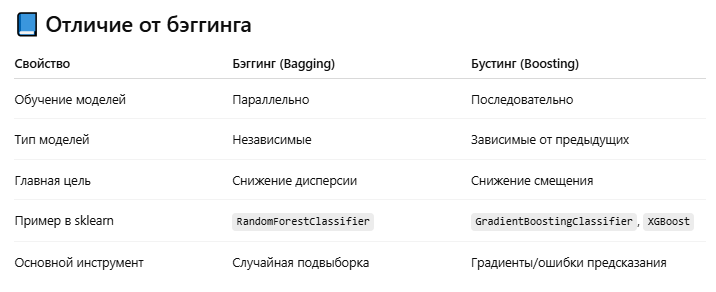

In [1]:
from IPython.display import Image
Image('dif.png')

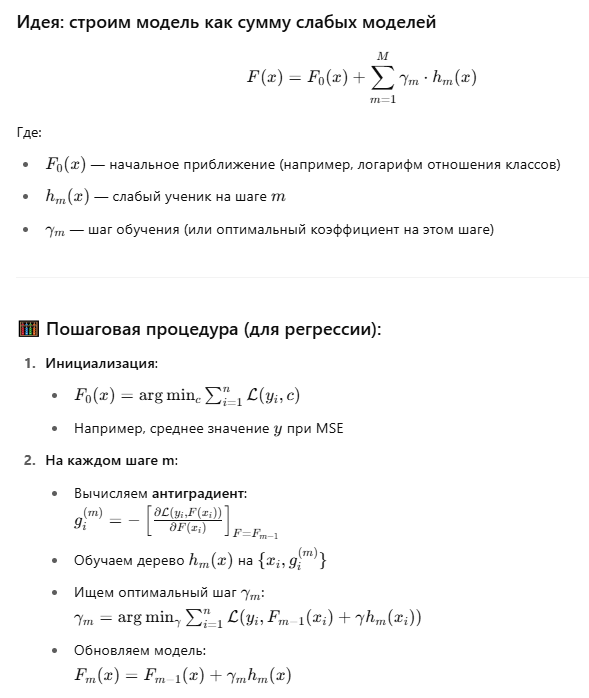

In [14]:
Image('../Boosting/Gradient boosting/steps.png')

## Почему именно деревья (обычно решающие деревья)?
### 1. Универсальность
Деревья могут аппроксимировать как линейные, так и сильно нелинейные зависимости. Они не требуют нормализации признаков, устойчивы к выбросам, и могут обрабатывать как числовые, так и категориальные переменные (если реализовано).

### 2. Слабая модель, но с высоким bias
В бустинге нужны слабые модели, то есть модели с высокой ошибкой (bias), но низкой дисперсией (variance). Маленькие деревья (обычно max_depth = 3...6) идеально подходят:
* они плохо переобучаются,
* но дают полезную информацию о структуре ошибки.

### 3. Скорость обучения и предсказания
Решающее дерево быстро обучается и предсказывает, особенно если оно неглубокое. А в бустинге таких деревьев может быть сотни или тысячи.

### 4. Гибкость
* Деревья хорошо работают с пропущенными значениями.
* Не требуют линейности в данных.
* Можно легко интерпретировать важность признаков (feature importance).

## Проблемы:
* Линейные модели (например, SGDRegressor):
    * Плохо справляются с сложными зависимостями.
    * Если первая модель ошиблась по какой-то причине — все остальные это не «поймут», потому что они тоже линейные.
* kNN или нейросети:
    * Долго обучаются.
    * Сложно обновлять модель итеративно.
    * Неустойчивы к шуму и переобучению.

## Вывод:
**Решающее дерево** — это золотая середина между слабостью и достаточной сложностью, позволяющей эффективно уменьшать ошибку на каждом шаге бустинга. Поэтому почти все реализации GBM (XGBoost, LightGBM, CatBoost, sklearn) используют деревья.

для **регрессии**, градиентный бустинг добавляет базовые модели в ансамбль последовательно, однако вместо обучения моделей с учётом весов на основе ошибок предшественников, в данном случае модели обучаются на остаточных ошибках (residual errors), допущенных предыдущими моделями.

### Алгоритм строится следующим образом:

1) первоначальному прогнозу присваивается среднее значение y_train для всех образцов;

2) рассчитываются остатки модели на основе антиградиента функции потерь;

3) регрессионное дерево обучается на X_train и остатках, далее делается прогноз на X_train;

4) полученный прогноз добавляется к первоначальному и шаги 2-4 повторяются для каждого дерева;

5) после обучения всех моделей снова создаётся первоначальный прогноз из шага 1;

6) далее делаются прогнозы для X_test на обученных деревьях и добавляются к первоначальному;

7) полученная сумма и будет конечным прогнозом.

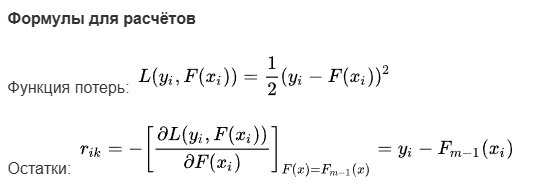

In [15]:
Image('../Boosting/Gradient boosting/func_reg.png')

В случае **классификации** дела обстоят немного сложнее: к каждому уникальному классу необходимо применить one-hot encoding и перевести в вероятности с помощью softmax-функции, а к прогнозам деревьев добавить коэффициент \gamma, который регулирует степень вклада каждого нового дерева в общую модель для снижения переобучения. Также качество прогнозов градиентного бустинга можно существенно улучшить, применив концепцию K-class LogitBoost: для каждого дерева рассчитываются веса, а только потом на их основе остатки.

### Алгоритм строится следующим образом:

1) для y_train применяется one-hot encoding и первоначальному прогнозу приcваиваются значения 0 для каждого класса;

2) прогнозы преобразуются в вероятности с помощью softmax-функции;

3) рассчитываются остатки модели на основе антиградиента функции потерь и вероятностей (а также веса в случае LogitBoost);

4) регрессионное дерево обучается на X_train и остатках (а в случае LogitBoost ещё присваиваются веса), далее делается прогноз на X_train;

5) для каждого листа в дереве рассчитываются коэффициенты \gamma на основе остатков, взятых по позициям наблюдений, попавших в определённый в листовой узел;

6) полученные прогнозы для каждого класса и сумма коэффициентов \gamma добавляются к первоначальным;

7) шаги 2-6 повторяются для каждого дерева в каждом классе;

8) после обучения всех моделей создаётся первоначальный прогноз из шага 1;

9) далее делаются прогнозы для X_test на обученных деревьях по каждому классу и добавляются к первоначальным;

10) классы с максимальной суммой и будут конечным прогнозом.

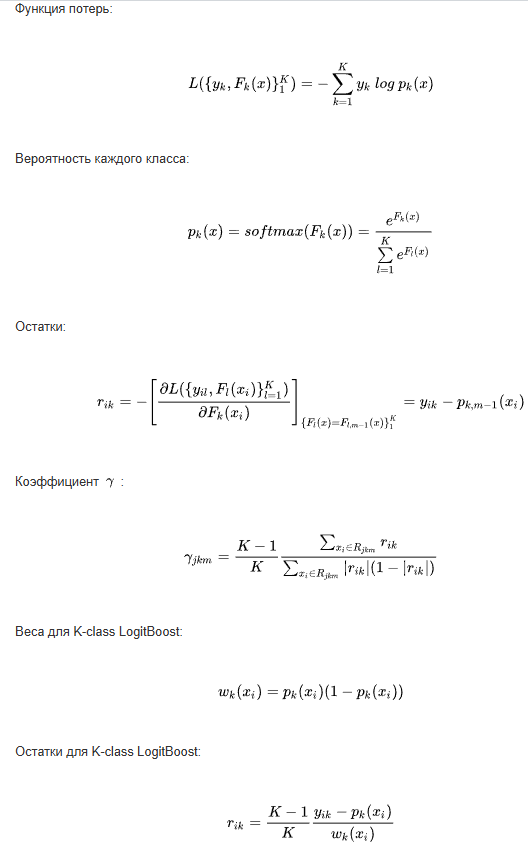

In [16]:
Image('../Boosting/Gradient boosting/func_class.png')

In [23]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class GBMRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees_ = []
        self.init_prediction_ = None


    def fit(self, X, y):
        # Инициализация модели — среднее значение по y
        self.init_prediction_ = np.mean(y)
        current_prediction = np.full(y.shape, self.init_prediction_)

        for i in range(self.n_estimators):
            residual = y - current_prediction
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residual)
            update = tree.predict(X)

            # Обновляем предсказания
            current_prediction += self.learning_rate * update
            self.trees_.append(tree)

        return self


    def predict(self, X):
        pred = np.full((X.shape[0],), self.init_prediction_)
        for tree in self.trees_:
            pred += self.learning_rate * tree.predict(X)

        return pred

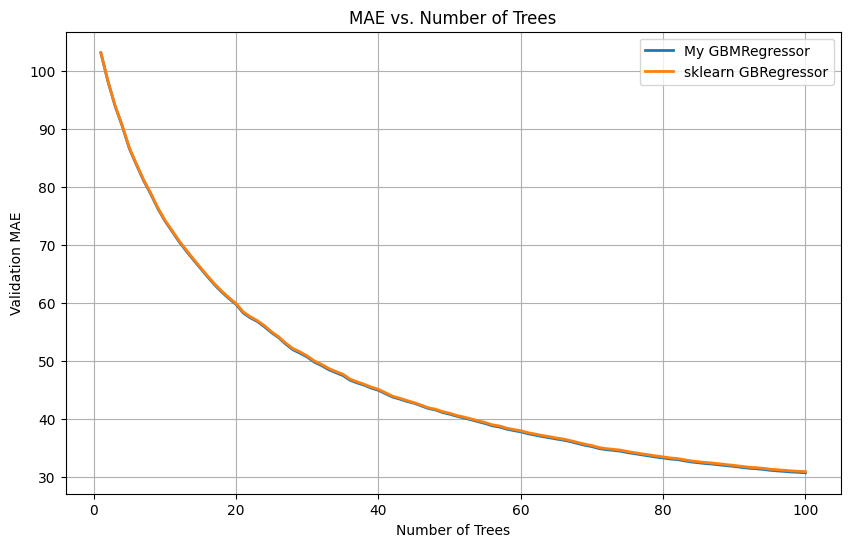

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

# Предположим, что GBMRegressor уже определен
# from your_gbm_file import GBMRegressor

# 1. Генерируем данные
X, y = make_regression(n_samples=1000, n_features=10, noise=15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Обучение моделей
n_estimators = 100
learning_rate = 0.1
max_depth = 3

# 2.1 Моя реализация
my_model = GBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
my_model.fit(X_train, y_train)

# 2.2 Sklearn модель с теми же параметрами
sk_model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
sk_model.fit(X_train, y_train)

# 3. Считаем MAE на валидации на каждой итерации
mae_my = []
mae_sk = []

# Предсказания вручную: суммируем деревья по частям
y_pred_my = np.zeros_like(y_val)
for i, tree in enumerate(my_model.trees_):
    y_pred_my += learning_rate * tree.predict(X_val)
    mae_my.append(mean_absolute_error(y_val, y_pred_my))

# Sklearn: staged_predict возвращает генератор промежуточных предсказаний
for y_pred_sk in sk_model.staged_predict(X_val):
    mae_sk.append(mean_absolute_error(y_val, y_pred_sk))

# 4. График
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_estimators + 1), mae_my, label="My GBMRegressor", lw=2)
plt.plot(range(1, n_estimators + 1), mae_sk, label="sklearn GBRegressor", lw=2)
plt.xlabel("Number of Trees")
plt.ylabel("Validation MAE")
plt.title("MAE vs. Number of Trees")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
abs(np.mean(mae_my) - np.mean(mae_sk))

0.1673198461245562

### В задачах классификации идея градиентного бустинга сохраняется, но:
* Целевая переменная дискретна (например, классы 0/1),
* Ошибка (loss) другая: вместо MSE обычно используется логистическая (log-loss) или экспоненциальная (AdaBoost),
* Итоговая модель строит предсказания в логит-пространстве, которые затем проходят через sigmoid.

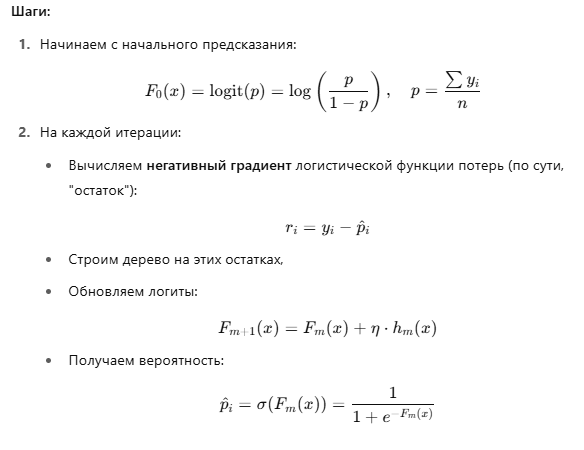

In [30]:
Image('../Boosting/Gradient boosting/step_log.png')

In [31]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class GBMClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.F0 = None

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        y = np.array(y)
        # Начальное предсказание: логарифм отношения вероятностей (логит)
        p = np.clip(np.mean(y), 1e-5, 1 - 1e-5)
        self.F0 = np.log(p / (1 - p))
        Fm = np.full(len(y), self.F0)

        for _ in range(self.n_estimators):
            # Промежуточные вероятности
            prob = self._sigmoid(Fm)
            # Негативный градиент логлосса
            gradient = y - prob
            # Обучаем дерево на этом градиенте
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, gradient)
            self.trees.append(tree)
            # Обновляем логиты
            Fm += self.learning_rate * tree.predict(X)

    def predict_proba(self, X):
        Fm = np.full(X.shape[0], self.F0)
        for tree in self.trees:
            Fm += self.learning_rate * tree.predict(X)
        prob = self._sigmoid(Fm)
        return np.vstack([1 - prob, prob]).T  # [P(0), P(1)]

    def predict(self, X):
        prob = self.predict_proba(X)[:, 1]
        return (prob >= 0.5).astype(int)


In [33]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Данные
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем мою модель
model = GBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# Предсказания и метрики
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8633333333333333


In [34]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators_list = list(range(1, 101, 5))
acc_custom = []
acc_sklearn = []

for n_estimators in n_estimators_list:
    # Моя реализация
    clf_custom = GBMClassifier(n_estimators=n_estimators, learning_rate=0.1, max_depth=3)
    clf_custom.fit(X_train, y_train)
    y_pred_custom = clf_custom.predict(X_test)
    acc_custom.append(accuracy_score(y_test, y_pred_custom))

    # Sklearn реализация
    clf_sklearn = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=0.1, max_depth=3)
    clf_sklearn.fit(X_train, y_train)
    y_pred_sklearn = clf_sklearn.predict(X_test)
    acc_sklearn.append(accuracy_score(y_test, y_pred_sklearn))


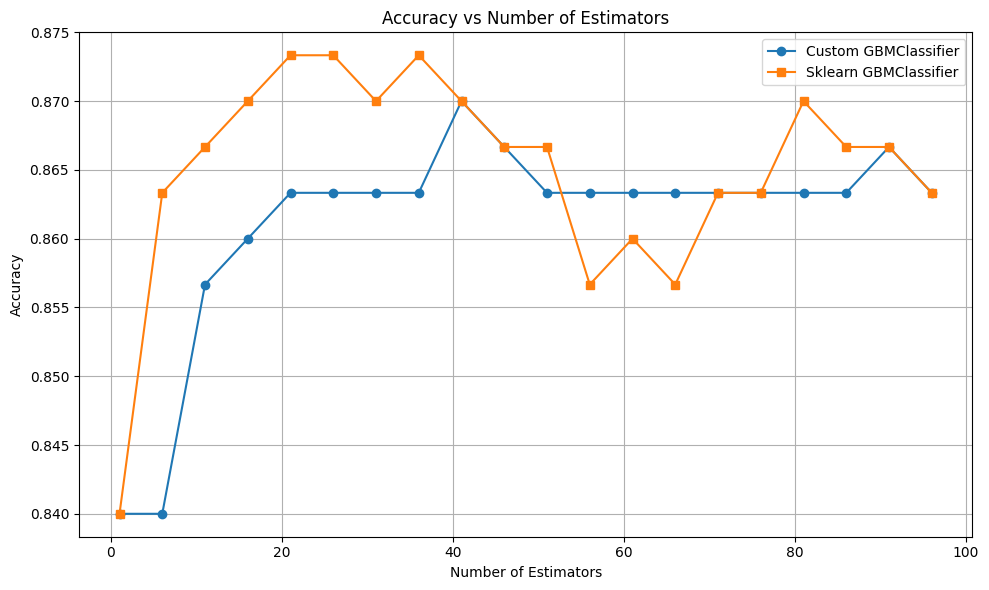

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, acc_custom, label="Custom GBMClassifier", marker='o')
plt.plot(n_estimators_list, acc_sklearn, label="Sklearn GBMClassifier", marker='s')
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Estimators")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 в принципе близко, где лучше, где то хуже, главное - понятен смысл

# Преимущества и недостатки градиентного бустинга (GBM)
### Преимущества:
* высокая точность;
* хорошо работает с неоднородными данными;
* лежит в основе других модификаций градиентного бустинга.
### Недостатки:
* низкая скорость обучения при работе с большими датасетами;
* отсутствие возможности работы с категориальными признаками;
* возможность переобучения из-за плохой предобработки данных.